In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/features.txt"

feature_name_df = pd.read_csv(url, sep='\s+', header=None, names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:, 1].values.tolist()

In [2]:
X_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/X_train.txt'
X_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/X_test.txt'

X_train = pd.read_csv(X_train_url, sep='\s+', header=None)
X_test = pd.read_csv(X_test_url, sep='\s+', header=None)

In [3]:
X_train.colmns = feature_name
X_test.columns = feature_name

<ipython-input-3-20ea1e28c453>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_train.colmns = feature_name


In [4]:
y_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/y_train.txt'
y_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/y_test.txt'

y_train = pd.read_csv(y_train_url, sep='\s+', header=None, names=['action'])
y_test = pd.read_csv(y_test_url, sep='\s+', header=None, names=['action'])

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [6]:
from sklearn.decomposition import PCA

def get_pca_data(ss_data, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)
    
    return pca.transform(ss_data), pca

In [7]:
HAR_pca, pca =  get_pca_data(X_train, n_components=2)
HAR_pca.shape

(7352, 2)

In [8]:
pca

PCA(n_components=2)

In [9]:
pca.mean_.shape, pca.components_.shape

((561,), (2, 561))

In [10]:
cols = ['pca_'+str(n) for n in range(pca.components_.shape[0])]
cols

['pca_0', 'pca_1']

In [11]:
def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_'+str(n) for n in range(col_num)]
    return pd.DataFrame(pca_data, columns=cols)

In [12]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train
HAR_pd_pca.head()

,pca_0,pca_1,action
0,-5.520280,-0.290278,5
1,-5.535350,-0.082530,5
2,-5.474988,0.287387,5
3,-5.677232,0.897031,5
4,-5.748749,1.162952,5


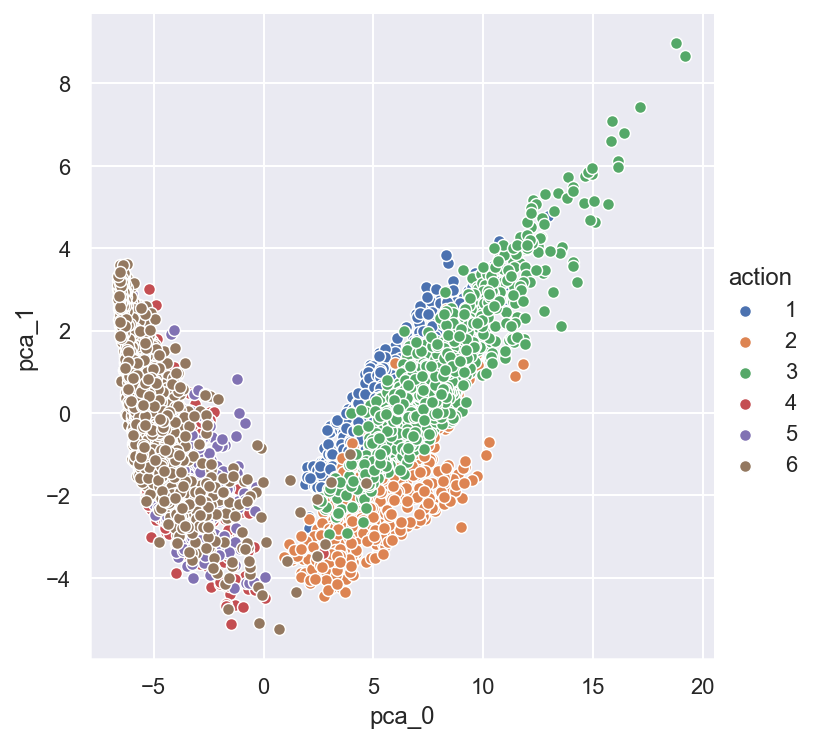

In [13]:
import seaborn as sns

sns.pairplot(HAR_pd_pca, hue='action', height=5, x_vars=['pca_0'], y_vars=['pca_1']);

In [14]:
import numpy as np

def print_variance_ratio(pca):
    print('variance_ratio : ', pca. explained_variance_ratio_)
    print('sum of variance_ratio : ', np.sum(pca.explained_variance_ratio_))
    
print_variance_ratio(pca)

variance_ratio :  [0.6255444  0.04913023]
sum of variance_ratio :  0.6746746270487946


In [16]:
HAR_pca, pca = get_pca_data(X_train, n_components=3)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train

print_variance_ratio(pca)

variance_ratio :  [0.6255444  0.04913023 0.04121467]
sum of variance_ratio :  0.7158893015785895


In [25]:
HAR_pca, pca = get_pca_data(X_train, n_components=10)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train

print_variance_ratio(pca)

variance_ratio :  [0.6255444  0.04913023 0.04121467 0.01874956 0.0169486  0.01272069
 0.01176685 0.01068973 0.0096938  0.00858005]
sum of variance_ratio :  0.8050385815976213


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth' : [6, 8, 10],
    'n_estimators' : [50, 100, 200],
    'min_samples_leaf' : [8, 12],
    'min_samples_split' : [8, 12]
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(HAR_pca, y_train.values.reshape(-1,))

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [50, 100, 200]})

In [27]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_results_df[target_col].sort_values('rank_test_score').head()

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
17,1,0.837867,200,8
1,1,0.837867,100,6
4,1,0.837867,100,6
14,1,0.837867,200,8
29,5,0.837459,200,10


In [28]:
grid_cv.best_params_

{'max_depth': 6,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 100}

In [29]:
grid_cv.best_score_

0.8378672470076169

In [30]:
from sklearn.metrics import accuracy_score

rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(HAR_pca, y_train.values.reshape(-1,))

pred1 = rf_clf_best.predict(pca.transform(X_test))

accuracy_score(y_test, pred1)

0.8473023413640991

In [31]:
import time
from xgboost import XGBClassifier

evals = [(pca.transform(X_test), y_test)]

start_time = time.time()
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(HAR_pca, y_train.values.reshape(-1,), early_stopping_rounds=10, eval_set=evals)
print('Fit time : ', time.time() - start_time)

[0]	validation_0-merror:0.22498
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.22192
[2]	validation_0-merror:0.21310
[3]	validation_0-merror:0.20394
[4]	validation_0-merror:0.20190
[5]	validation_0-merror:0.20326
[6]	validation_0-merror:0.19681
[7]	validation_0-merror:0.19817
[8]	validation_0-merror:0.19477
[9]	validation_0-merror:0.19206
[10]	validation_0-merror:0.19138
[11]	validation_0-merror:0.18765
[12]	validation_0-merror:0.18663
[13]	validation_0-merror:0.18493
[14]	validation_0-merror:0.18188
[15]	validation_0-merror:0.18120


/Users/seogihyun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[16]	validation_0-merror:0.18018
[17]	validation_0-merror:0.17713
[18]	validation_0-merror:0.17849
[19]	validation_0-merror:0.17645
[20]	validation_0-merror:0.17645
[21]	validation_0-merror:0.17509
[22]	validation_0-merror:0.17374
[23]	validation_0-merror:0.17408
[24]	validation_0-merror:0.17306
[25]	validation_0-merror:0.17441
[26]	validation_0-merror:0.17272
[27]	validation_0-merror:0.17034
[28]	validation_0-merror:0.16831
[29]	validation_0-merror:0.16865
[30]	validation_0-merror:0.16966
[31]	validation_0-merror:0.16933
[32]	validation_0-merror:0.16865
[33]	validation_0-merror:0.16763
[34]	validation_0-merror:0.16525
[35]	validation_0-merror:0.16593
[36]	validation_0-merror:0.16457
[37]	validation_0-merror:0.16390
[38]	validation_0-merror:0.16322
[39]	validation_0-merror:0.16593
[40]	validation_0-merror:0.16525
[41]	validation_0-merror:0.16525
[42]	validation_0-merror:0.16491
[43]	validation_0-merror:0.16356
[44]	validation_0-merror:0.16220
[45]	validation_0-merror:0.16288
[46]	valid

In [32]:
accuracy_score(y_test, xgb.predict(pca.transform(X_test)))

0.8673227010519172